<img src='https://www.met.no/om-oss/logo/_/image/73f29cde-219f-487b-809c-9cdd61032c78:2efc46ce776f5f5337c4b0156ae0cbaa3b6bf6fe/width-768/Met_RGB_Horisontal.jpg' width=200 align=right>
<img src='https://raw.githubusercontent.com/norkyst/norkyst-logo/refs/heads/main/png/horizontal_35_91_100.png' width=200 align=right>

# __UNDER CONSTRUCTION__

# Vertical cross-sections using Norkyst v3 data

This notebook will give instructions, tips and tricks on how to access data from MET's THREDDS server and how to visualize it. The main focus will be plotting vertical cross sections and making streamplots using the new Norkyst model, Norkyst v3. 

The goal is a vertical cross-section with the bottom topography shown, filled contour of a 3D-variable with distance on the x-axis and depth on the y-axis. The section will be determined by two arbitrary positions in latitude/longitude, inside the model domain. 

__Python requirements__:

To access data from the model and extracting it into datasets we will make use of some Python packages.

Xarray will be the main tool to opening the datasets, and allows us to display the contents nicely. Cartopy and matplotlib are the main plotting tools, in addition to Cmocean for colormaps. 

If you are unfamiliar with these packages or need help, please see the documentations listed below.

**Useful documentation**:

* Cartopy: https://scitools.org.uk/cartopy/docs/latest/
* Cmocean: https://matplotlib.org/cmocean/
* Matplotlib: https://matplotlib.org/stable/
* NumPy: https://numpy.org/doc/
* Xarray:https://docs.xarray.dev/en/stable/

In [1]:
# Importing useful python libraries

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmocean
import xroms
import netCDF4
import roppy

### Accessing the data

Data can be found at https://thredds.met.no/thredds/catalog.html.
Locate project, folder and files. Here we will use OPENDAP url to read in the data.
To get the OPENDAP URL, click on the desired NetCDF file (.nc). Under the "ACCESS" section, select the OPENDAP URL and then copy the URL located under "DATA URL".

In [6]:
# Reading in the path from thredds.met.no, using an OPENDAP url
path = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkystv3_800m_m00_be'

# Opening a netCDF file as xarray dataset
ds = xr.open_dataset(path)

# Viewing the dataset
ds

<xarray.Dataset>
Dimensions:                  (X: 2747, Y: 1148, depth: 15, time: 11591)
Coordinates:
  * X                        (X) int32 0 800 1600 ... 2195200 2196000 2196800
  * Y                        (Y) int32 0 800 1600 2400 ... 916000 916800 917600
  * depth                    (depth) float64 0.0 1.0 2.0 ... 100.0 200.0 300.0
  * time                     (time) datetime64[ns] 2024-01-01 ... 2025-05-03
    lon                      (Y, X) float64 ...
    lat                      (Y, X) float64 ...
Data variables:
    projection_stere         int32 ...
    forecast_reference_time  float64 ...
    h                        (Y, X) float64 ...
    zeta                     (time, Y, X) float32 ...
    u_eastward               (time, depth, Y, X) float32 ...
    v_northward              (time, depth, Y, X) float32 ...
    w                        (time, depth, Y, X) float32 ...
    temperature              (time, depth, Y, X) float32 ...
    salinity                 (time, depth, Y, X) float32 ...
    AKs                      (time, depth, Y, X) float32 ...
    Uwind_eastward           (time, Y, X) float32 ...
    Vwind_northward          (time, Y, X) float32 ...
Attributes: (12/37)
    id:                         0413e08c-cf07-4a2f-a7a0-3d25aea39e6d
    naming_authority:           no.met
    operational_status:         Operational
    iso_topic_category:         oceans
    activity_type:              Numerical Simulation
    keywords_vocabulary:        GCMDSK:GCMD Science Keywords:https://gcmd.ear...
    ...                         ...
    dataset_production_status:  In Work
    license:                    https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                      Norkyst-800m - ROMS, Norkyst-800m 120 hours o...
    summary:                    Norkyst-800m (Norwegian Coast 800m horizontal...
    title_no:                   120 timers prognoser fra havmodellen Norkyst-...
    summary_no:                 NorKyst-800m (Norske kystområder med 800m hor...

In [7]:
Filepath = "https://thredds.met.no/thredds/dodsC/romshindcast/norkyst_v3/sdepth/2024/05/norkyst800-20240531.nc"

#ds_s = xroms.open_netcdf(path)

In [8]:
grid = roppy.SGrid(netCDF4.Dataset(Filepath))

In the drop-down menu above you have an overview of the chosen dataset.

In [9]:
# Saving the timestep for later
time = ds.time[5]

# Making a subset containing only one timestep
ds = ds.isel(time=5)

In [10]:
# The transect we will be working with
lat_sec = np.array([59.04, 57.79]) # start_lat, end_lat
lon_sec = np.array([10.62, 10.56])  # start_lon, end_lon

We can start by showing the chosen transect on a map.

Text(0.5, 1.0, 'Sea surface height at 2024-01-01T05:00:00.000000000')

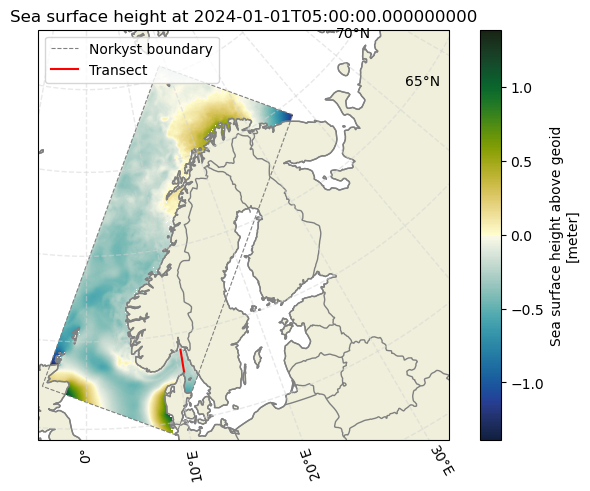

In [11]:
# Choosing a map projection
proj = ccrs.NorthPolarStereo()

# Making figure and axes with the projection
fig, ax = plt.subplots(subplot_kw={'projection': proj}, constrained_layout=True)

# Setting the extent of the map to our model domain
ax.set_extent([np.min(ds.lon), np.max(ds.lon), np.min(ds.lat), np.max(ds.lat)], crs=ccrs.PlateCarree())  # ccrs.PlateCarree() to tell the program our data is in coordinates lats/lons

# Adding natural features to our map
land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')
borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', edgecolor= 'gray', scale='50m', facecolor='none')

ax.add_feature(land)
ax.add_feature(coastline)
ax.add_feature(borders)

# Adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plotting boundaries of model
ax.plot(ds.lon[0,:], ds.lat[0,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =0.8)
ax.plot(ds.lon[-1,:], ds.lat[-1,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =0.8)  
ax.plot(ds.lon[:,0], ds.lat[:,0], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =0.8)
ax.plot(ds.lon[:,-1], ds.lat[:,-1], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =0.8, label='Norkyst boundary')

# Plotting sea surface height
ds.zeta.plot(ax = ax, x = 'lon', y = 'lat', transform = ccrs.PlateCarree(), cmap=cmocean.cm.delta)

# Adding transect
ax.plot([lon_sec[0], lon_sec[1]], [lat_sec[0], lat_sec[1]], transform = ccrs.PlateCarree(), color = 'r', label = 'Transect')

# Adding legend
ax.legend(loc = 'upper left')

# Adding title
ax.set_title(f'Sea surface height at {time.values}')

In [13]:
# Convert lon/lat to x,y gridpoints
x1, y1 = grid.ll2xy(lon_sec[0], lat_sec[0])
x2, y2 = grid.ll2xy(lon_sec[1], lat_sec[1])

# Find nearest indices to transect
i1, j1, i2, j2 = (int(round(i)) for i in (x1, y1, x2, y2))

KeyError: 'lon_rho'

In [12]:
""" ds.temperature.isel(Y=1000).plot()
plt.ylim(plt.ylim()[::-1])  # Revert the vertical axis """

' ds.temperature.isel(Y=1000).plot()\nplt.ylim(plt.ylim()[::-1])  # Revert the vertical axis '

In [7]:
# Making a separate grid object using roppy and netCDF4
#grid = roppy.SGrid(netCDF4.Dataset(path))

In [8]:
# Convert lon/lat to x,y gridpoints
#x1, y1 = grid.ll2xy(lon_sec[0], lat_sec[0])
#x2, y2 = grid.ll2xy(lon_sec[1], lat_sec[1])

Note to self:
* Possible to use oceanspy for cross section?
* Or make own functions for making a transect and section as in roppy but for Norkyst v3?